In [1]:
from phi.torch.flow import *
import tqdm

device = torch.device('cuda')

In [2]:
BOUNDS = Box(x=1, y=1)
RESOLUTION = 100

In [3]:
@jit_compile
def step(v, s, dt, inflow):
    s = advect.mac_cormack(s, v, dt) + 0.2 * resample(inflow, to=s, soft=True)
    buoyancy = resample(s * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, _ = fluid.make_incompressible(v, (), Solve('auto', 1e-3))
    return v, s

In [4]:
v0 = StaggeredGrid(
    values=0,
    extrapolation=extrapolation.ZERO,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)
smoke0 = CenteredGrid(
    values=0,
    extrapolation=extrapolation.ZERO_GRADIENT,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)
inflow0 = Sphere(x=0.5, y=0.15, radius=0.1)

In [5]:
vel, smoke = v0, smoke0
vel_list = []
smoke_list = []
for _ in tqdm.trange(100):
    vel, smoke = step(vel, smoke, 0.2, inflow0)
    vel_list.append(vel)
    smoke_list.append(smoke)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\imeho\Documents\VituralEnvs\InstantPINF-TCNN\Lib\site-packages\phiml\backend\torch\_torch_backend.py:803: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)
100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


C:\Users\imeho\Documents\VituralEnvs\InstantPINF-TCNN\Lib\site-packages\phi\vis\_matplotlib\_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


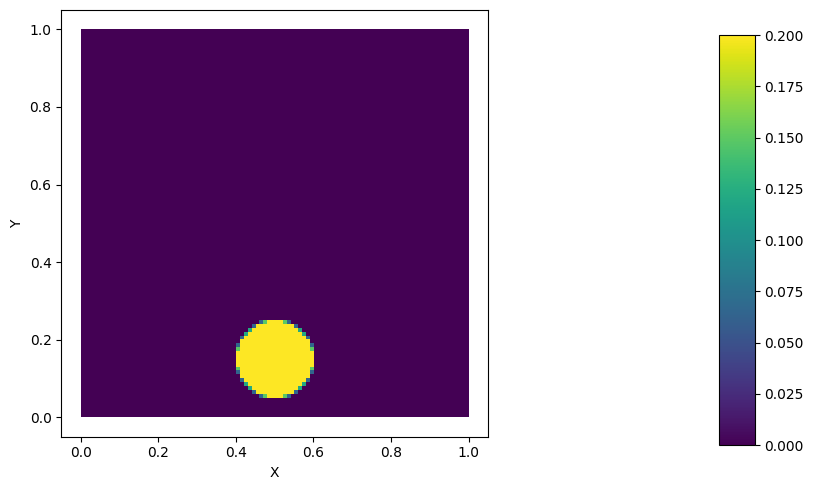

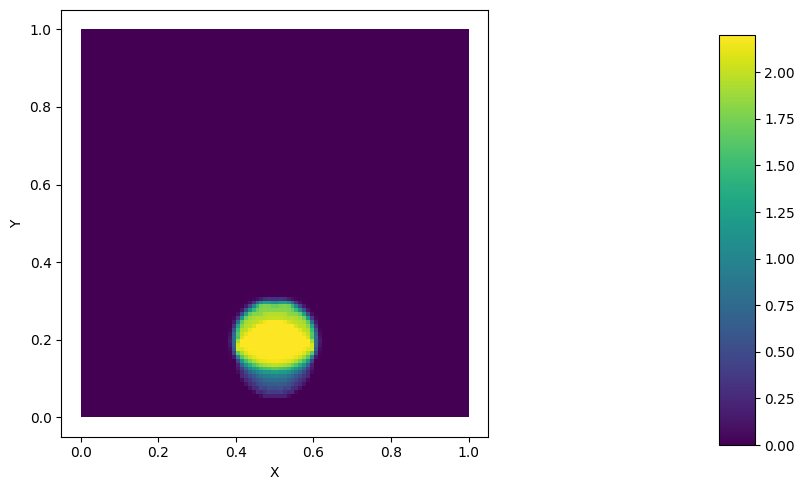

In [6]:
sim_iters = 10
smoke_record_start = smoke_list[00]
smoke_record_end = smoke_list[00 + sim_iters]
_ = plot(smoke_record_start)
_ = plot(smoke_record_end)

In [7]:
A = 0.2
sigma = 0.2
x = torch.linspace(0.2, 0.8, 3, dtype=torch.float32, device=device, requires_grad=True)
y = torch.linspace(0.2, 0.8, 3, dtype=torch.float32, device=device, requires_grad=True)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
LOC_SRC = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)
LOCATIONS = wrap(LOC_SRC, instance('locations'), channel(vector='x,y'))
DIRECTIONS = math.ones(LOCATIONS.shape)


# @jit_compile
def step_sim(v, s, dt, inflow, in_force):
    s = advect.mac_cormack(s, v, dt) + 0.2 * resample(inflow, to=s, soft=True)
    v = advect.semi_lagrangian(v, v, dt) + resample(in_force, to=v) * dt
    return v, s


@jit_compile
def loss_function(in_loc, in_dir):
    GAUSS_FORCE_FIELD = CenteredGrid(
        values=lambda x, y: sum(
            math.exp(-length(in_loc.locations[i] - vec(x=x, y=y)) ** 2 / (2 * sigma ** 2)) * in_dir.locations[i]
            for i in range(instance(in_loc).size)
        ),
        extrapolation=extrapolation.ZERO_GRADIENT,
        bounds=BOUNDS,
        resolution=spatial(x=RESOLUTION, y=RESOLUTION),
    )
    iter_den, iter_vel = smoke_record_start, v0
    for _ in range(sim_iters):
        iter_vel, iter_den = step_sim(iter_vel, iter_den, 0.2, inflow0, GAUSS_FORCE_FIELD)
    return math.l2_loss(iter_den.values - smoke_record_end.values)


grad_fun = math.gradient(loss_function, wrt='in_loc, in_dir', get_output=True)


def gradient_descent_step(in_loc, in_dir, learning_rate=.001):
    out_loss, (d_loc, d_dir) = grad_fun(in_loc, in_dir)
    return out_loss, in_loc - learning_rate * d_loc, in_dir - learning_rate * d_dir

In [8]:
losses = []
train_loc = LOCATIONS
train_dir = DIRECTIONS
for _ in tqdm.trange(1000):
    loss, train_loc, train_dir = gradient_descent_step(train_loc, train_dir)
    losses.append(loss)

100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]


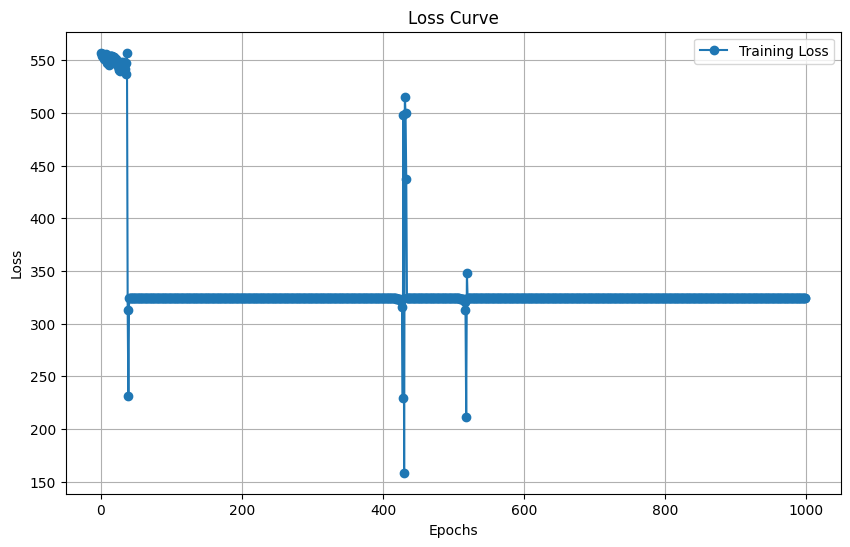

In [9]:
import matplotlib.pyplot as plt

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss", linestyle='-', marker='o')  # 使用线条和标记
plt.xlabel("Epochs")  # 横轴标签
plt.ylabel("Loss")  # 纵轴标签
plt.title("Loss Curve")  # 图标题
plt.legend()  # 显示图例
plt.grid(True)  # 添加网格
plt.show()

In [10]:
in_loc, in_dir = train_loc, train_dir
GAUSS_FORCE_FIELD = CenteredGrid(
    values=lambda x, y: sum(
        math.exp(-length(in_loc.locations[i] - vec(x=x, y=y)) ** 2 / (2 * sigma ** 2)) * in_dir.locations[i]
        for i in range(instance(in_loc).size)
    ),
    extrapolation=extrapolation.ZERO,
    bounds=BOUNDS,
    resolution=spatial(x=RESOLUTION, y=RESOLUTION),
)
iter_den, iter_vel = smoke_record_start, v0
for _ in range(sim_iters):
    iter_vel, iter_den = step_sim(iter_vel, iter_den, 0.2, inflow0, GAUSS_FORCE_FIELD)

C:\Users\imeho\Documents\VituralEnvs\InstantPINF-TCNN\Lib\site-packages\phi\vis\_matplotlib\_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


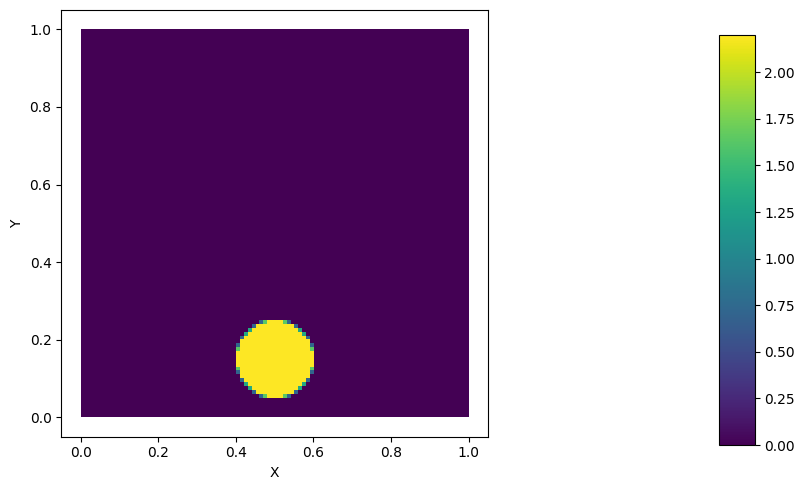

In [11]:
_ = plot(iter_den)

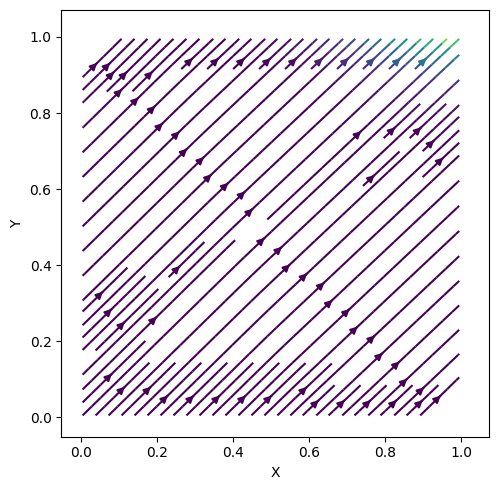

In [12]:
_ = plot(GAUSS_FORCE_FIELD)